# embedding

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from plantclef.config import get_device

print(f"PyTorch Version: {torch.__version__}")
device = get_device()
print(f"Using device: {device}")

PyTorch Version: 2.6.0
Using device: cpu


In [3]:
import pandas as pd
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path().resolve().parents[0]
print(root)
! date

/Users/mgustineli/github/pytorch-plantclef
Wed Mar 19 17:50:35 EDT 2025


In [4]:
# path to data
data_path = f"{root}/data/parquet/"
train_path = f"{data_path}/subset_top5_train"
test_path = f"{data_path}/test_2025_pytorch_webinar"

# read train/test data
train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

# display data
print(train_df.shape)
display(train_df.head(3))
display(test_df.head(3))

(3760, 22)


,species_id,image_name,path,data,organ,obs_id,license,partner,author,altitude,...,gbif_species_id,species,genus,family,dataset,publisher,references,url,learn_tag,image_backup_url
0,1360257,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,/PlantCLEF2024/train/1360257/5a4deafc321f2b653...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,bark,1015292920,cc-by-sa,None,Gabor Graehn,NaN,...,3039454.0,Frangula alnus Mill.,Frangula,Rhamnaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/5a4deafc321f2b...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
1,1360257,a6d9a13ec26cbb04d61861ad5cb4ede8eb4d1ea3.jpg,/PlantCLEF2024/train/1360257/a6d9a13ec26cbb04d...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,bark,1005087257,cc-by-sa,None,Jacco Sanders,51.0,...,3039454.0,Frangula alnus Mill.,Frangula,Rhamnaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/a6d9a13ec26cbb...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
2,1360257,0fec55fc5105e512df08490ecbb55df3393d85c8.jpg,/PlantCLEF2024/train/1360257/0fec55fc5105e512d...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,leaf,4111721487,http://creativecommons.org/licenses/by-nc/4.0/,None,imrsmf,NaN,...,3039454.0,Frangula alnus Mill.,Frangula,Rhamnaceae,gbif,iNaturalist,https://www.inaturalist.org/photos/268971946,https://inaturalist-open-data.s3.amazonaws.com...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...


,image_name,path,data
0,CBN-PdlC-C4-20180723.jpg,/test/data/PlantCLEF/PlantCLEF2025/DataOut/tes...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1,LISAH-BOU-0-30-20230512.jpg,/test/data/PlantCLEF/PlantCLEF2025/DataOut/tes...,b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x0...
2,CBN-PdlC-C4-20140811.jpg,/test/data/PlantCLEF/PlantCLEF2025/DataOut/tes...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...


### extract embeddings from images

In [5]:
# limit to 5 samples for testing
limit_df = train_df.head(2)
print(f"Limit DF shape: {limit_df.shape}")

Limit DF shape: (2, 22)


In [6]:
from plantclef.embed.workflow import inference_pipeline

# extract embeddings
embeddings, logits = inference_pipeline(
    limit_df,
    batch_size=2,
    use_grid=False,
    cpu_count=1,
)

Extracting embeddings and logits: 100%|██████████| 1/1 [00:04<00:00,  4.40s/batch]


In [7]:
# embeddings shape
embeddings.shape

(2, 768)

In [8]:
# create embeddings dataframe
cols = ["image_name", "species", "species_id"]
embeddings_df = limit_df[cols].copy()
embeddings_df["embeddings"] = embeddings.tolist()
embeddings_df.head(2)

,image_name,species,species_id,embeddings
0,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,"[-0.8239141702651978, 1.2448816299438477, 0.02..."
1,a6d9a13ec26cbb04d61861ad5cb4ede8eb4d1ea3.jpg,Frangula alnus Mill.,1360257,"[-0.14528469741344452, -0.8409067988395691, -0..."


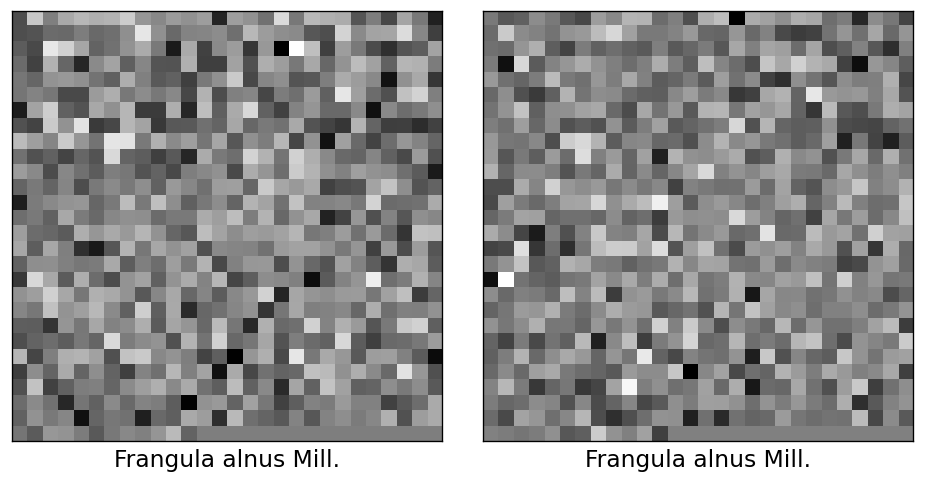

In [9]:
from plantclef.plotting import plot_embeddings

plot_embeddings(
    embeddings_df,
    data_col="embeddings",
    label_col="species",
    grid_size=(1, 2),
    figsize=(8, 4),
    dpi=120,
)

## grid of image tiles

In [10]:
# use grid to extract embeddings for each tile
USE_GRID = True
GRID_SIZE = 3

# extract embeddings
embeddings, logits = inference_pipeline(
    limit_df,
    batch_size=2,
    use_grid=USE_GRID,
    grid_size=GRID_SIZE,
    cpu_count=1,
)

Extracting embeddings and logits: 100%|██████████| 1/1 [00:13<00:00, 13.41s/batch]


In [11]:
# embeddings shape
embeddings.shape

(2, 9, 768)

In [12]:
# create embeddings dataframe
cols = ["image_name", "species", "species_id", "data"]
embeddings_df = limit_df[cols].copy()
embeddings_df["embeddings"] = embeddings.tolist()
embeddings_df.head(2)

,image_name,species,species_id,data,embeddings
0,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[[-0.5858300924301147, -0.12547707557678223, 0..."
1,a6d9a13ec26cbb04d61861ad5cb4ede8eb4d1ea3.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[[-0.0179920494556427, -0.5721642374992371, 0...."


In [13]:
embeddings_df["embeddings"].apply(lambda x: len(x))

0    9
1    9
Name: embeddings, dtype: int64

In [15]:
# explode embeddings
explode_df = embeddings_df.explode("embeddings", ignore_index=True)
# assign tile number for each image
explode_df["tile"] = explode_df.groupby("image_name").cumcount()
explode_df.head(9)

,image_name,species,species_id,data,embeddings,tile
0,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.5858300924301147, -0.12547707557678223, 0....",0
1,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.4382806122303009, -0.7402958273887634, 0.0...",1
2,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.7558999061584473, 0.8920708894729614, -1.0...",2
3,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.686843752861023, 0.21441468596458435, -0.3...",3
4,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[0.03154247999191284, 1.341550588607788, -1.05...",4
5,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.45235031843185425, 0.22192221879959106, -0...",5
6,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.2614886164665222, 1.9578287601470947, -0.8...",6
7,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-1.4218535423278809, -0.16190171241760254, -0...",7
8,5a4deafc321f2b653f03cc238160a799b0bbb6b7.jpg,Frangula alnus Mill.,1360257,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[0.026297181844711304, -0.2350459098815918, -0...",8


### PyTorch Lightning

In [19]:
from plantclef.embed.workflow import trainer_pipeline

# get embeddings and logits
embeddings, logits = trainer_pipeline(
    limit_df,
    batch_size=1,
    use_grid=USE_GRID,
    grid_size=GRID_SIZE,
    cpu_count=1,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mgustineli/github/pytorch-plantclef/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/mgustineli/github/pytorch-plantclef/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [20]:
# embeddings shape
embeddings.shape

torch.Size([2, 9, 768])